In [1]:
import os, sys
from collections import defaultdict
from tqdm import tqdm
import time

In [2]:
import gymnasium as gym
from text_flappy_bird_gym import *
# from flappy_bird_gymnasium import *

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4, seed=0)
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=3, seed=0)

env.reset()

((13, 5), {'score': 0, 'player': [6, 7], 'distance': 13.92838827718412})

In [4]:
class QLearningAgent():
    def __init__(self, hyper):
        self.N_ACTIONS = hyper['N_ACTIONS']
        self.epsilon = hyper['epsilon']
        self.eps_decay = hyper['eps_decay']
        self.lr = hyper['lr']
        self.discount = hyper['discount']
        self.seed = hyper['seed']
        self.rand_generator = np.random.RandomState(hyper['seed'])
        self.Q = defaultdict(lambda: 0)
        
        self.pre_state = 0
        self.pre_action = 0
    
    def argmax(self, q_values):
        top = float('-inf')
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = [i]
            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)

    def agent_start(self, state):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.N_ACTIONS)
        else:
            action = self.argmax(current_q)
        
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_step(self, reward, state, episode, num_episodes):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.N_ACTIONS)
        else:
            action = self.argmax(current_q)
        
        self.Q[self.pre_state, self.pre_action] += self.lr*(reward + self.discount*max(current_q) - self.Q[self.pre_state, self.pre_action])
            
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_end(self, reward):
        self.Q[self.pre_state, self.pre_action] += self.lr * (reward - self.Q[self.pre_state, self.pre_action])
        

    def train(self, env, num_episodes):
        # self.num_episodes = num_episodes
        scores = []
        for episode in tqdm(range(num_episodes)):
            state, _ = env.reset()
            if episode == 0:
                action = self.agent_start(state)
            else:
                while True:
                    next_state, reward, done, _, info = env.step(action)
                    next_action = self.agent_step(reward, next_state, episode, num_episodes)
                    # if done:
                    #     self.agent_end(reward)
                    #     break
                    if (info['score'] >1e2) or done:
                        self.agent_end(reward)
                        break
                    state = next_state
                    action = next_action
                scores.append(info['score'])
            self.epsilon = max(self.epsilon * self.eps_decay, 0.005)
            if episode % 1000 == 0: print(self.epsilon)
        return np.array(scores)

    def test(self, env, n_episodes):
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            while not done:
                action = np.argmax([self.Q[state,0], self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                state = next_state
                if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                    break
            scores.append(info['score'])
        return np.array(scores), np.mean(np.array(scores))

    def run(self, env):
        state,_ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = np.argmax([self.Q[state,0], self.Q[state,1]])
            next_state, reward,done,_, info = env.step(action)
            episode_reward += reward
            state = next_state
            if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                break
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.1) # FPS
        return info['score']

In [5]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=2, seed=None)
env.reset()

((13, 4), {'score': 0, 'player': [6, 7], 'distance': 13.601470508735444})

In [6]:
hyper = {}
hyper['N_ACTIONS'] = 2
hyper['epsilon'] = 0.5
hyper['eps_decay'] = 0.9995
hyper['lr'] = 0
hyper['discount'] = 0
hyper['seed'] = None
hyper['rand_generator'] = np.random.RandomState(hyper['seed'])

list_lr = [0.4, 0.6, 0.8, 0.9]
list_discount = [1.0, 0.95, 0.9, 0.8, 0.7]
labels_lr = ["lr = 0.4", "lr = 0.5","lr = 0.6", "lr = 0.7","lr = 0.8", "lr = 0.9"]
labels_discount = ["discount = 1.0", "discount = 0.95","discount = 0.9", "discount = 0.85","discount = 0.8", "discount = 0.75", "discount = 0.7"]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=2, seed=None)
game = QLearningAgent(hyper)
n_episodes = 10000

train_scores = []

for lr in list_lr:
    for discount in list_discount:
        print("-------------------")
        print(f"Learning rate: {lr}, Discount: {discount}")
        hyper['lr'] = lr
        hyper['discount'] = discount
        game = QLearningAgent(hyper)
        train_score = game.train(env, n_episodes)
        window = 1000
        average_y = [np.mean(train_score[:window])]*window
        for ind in range(len(train_score) - window + 1):
            average_y.append(np.mean(train_score[ind:ind+window]))
        plt.plot(train_score)
        plt.plot(average_y)
        plt.xlabel("Episodes")
        plt.ylabel("Scores")
        plt.title(f"Learning rate: {lr}, Discount: {discount}")
        plt.show()
        _, test_score = game.test(env, 10)
        print("Game score:", test_score)

KeyError: 'seed'

(0.024874864811808794, 0.009148663151611577, 0.003364763511073312)

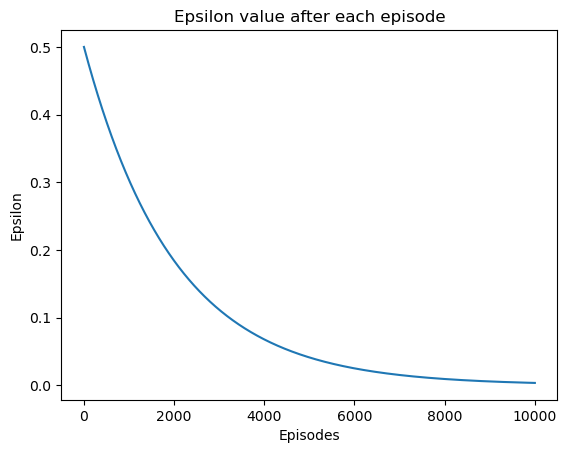

In [8]:
e = 0.5
ed = 0.9995
es = [e]
for i in range(10000):
    e = max(e*ed, 0.001)
    es.append(e)

plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.title("Epsilon value after each episode")
plt.plot(es)
es[6000], es[8000], es[10000]

In [ ]:
hyper = {}
hyper['N_ACTIONS'] = 2
hyper['epsilon'] = 0.5
hyper['eps_decay'] = 0.9995
hyper['lr'] = 0 ###
hyper['discount'] = 0 ###


env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=2, seed=None)

game = QLearningAgent(hyper)
train_score = game.train(env, n_episodes)
window = 1000
average_y = [np.mean(train_score[:window])]*window
for ind in range(len(train_score) - window + 1):
    average_y.append(np.mean(train_score[ind:ind+window]))
plt.plot(train_score)
plt.plot(average_y)
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title(f"Q_Learning Algorithm: Train")
plt.show()
test_score, _ = game.test(env, 100)
window = 10
average_test_y = [np.mean(test_score[:window])]*window
for ind in range(len(test_score) - window + 1):
    average_test_y.append(np.mean(test_score[ind:ind+window]))
plt.plot(test_score)
plt.plot(average_test_y)
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title(f"Q_Learning Algorithm: Test")

In [ ]:
# Convert dict Q to np array Q_ to save value in .csv file
def convert_Q(Q):
    Q_ = []
    for state in Q.keys():
        a = state[0][0]
        b = state[0][1]
        c = state[1]
        Q_.append([a,b,c,Q[((a,b),c)]])
    
    return np.array(Q_)

# Convert list Q_ from .csv file to dict Q
def convert_Q_(Q_):
    Q = defaultdict(lambda: 0)
    for row in Q_:
        [a,b,c,d] = row
        a,b,c = int(a), int(b), int(c)
        Q[((a,b), c)] = d
    return Q

Q_ = convert_Q(game.Q)
np.savetxt("Q_Learning_RandomEnv.csv", Q_, delimiter =",")